# Imports

In [1]:
import progressbar

In [2]:
import sys
import os
import requests
import pandas as pd

from pyspark import SparkContext, SparkConf
from pyspark.sql.session import SparkSession

In [3]:
app_name="Case Study 2"

conf = SparkConf().setAppName(app_name)
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

In [4]:
sc.applicationId

'local-1572132331912'

In [5]:
log4jLogger = sc._jvm.org.apache.log4j
LOGGER = log4jLogger.LogManager.getLogger(__name__)
LOGGER.info("pyspark script logger initialized")

# Load file as a text file in spark

In [6]:
def get_hdfs_filepath(file_name, on_cloud=True):
    # path to folder containing this code
    prefix = '/data/spark/5_cs2_dataset/'
    if on_cloud:
        bucket  = os.environ['BUCKET']
        file_path = bucket + prefix + file_name
    else:
        file_path = '/Users/val' + prefix + file_name

    return file_path

In [7]:
LOG = get_hdfs_filepath('access.log')
CLEAN_LOG = get_hdfs_filepath('access.clean.log')

In [8]:
print(LOG)

gs://drive3/data/spark/5_cs2_dataset/access.log


In [9]:
# read text file
text_file = sc.textFile(LOG).filter(lambda row: row!='')
text_file.take(150)

['109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette-raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette-raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '83.167.113.100 - - [12/Dec/2015:18:31:25 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '83.167.113.100 - - [12/Dec/2015:18:31:25 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://a

## Convert strings to columns

In [10]:
import datetime as dt
import dateutil.parser

def to_timestamp(string):
    timezone_str = string[string.find('+'):]
    date_time_str = string[:string.find('+')-1]
    date_time_obj = dt.datetime.strptime(date_time_str, '%d/%b/%Y:%H:%M:%S')
    dt2 = dateutil.parser.parse(str(date_time_obj)+timezone_str)
    return dt2

to_timestamp('12/Dec/2015:19:44:07 +0100')


datetime.datetime(2015, 12, 12, 19, 44, 7, tzinfo=tzoffset(None, 3600))

In [11]:
import re

class Switcher(object):
    def __init__(self, string):
        self.string = string
    
    def indirect(self,i):
        method_name='number_'+str(i)
        method=getattr(self,method_name,lambda :'Invalid')
        return method()

    def number_0(self):
        return self.string
    def number_1(self):
        return self.string
    def number_2(self):
        return to_timestamp(self.string)
    def number_3(self):
        return self.string[1:-1]
    def number_4(self):
        return self.string[1:-7]
    def number_5(self):
        return int(self.string[-3:])
    def number_6(self):
        return int(self.string[5:-1])
    

def my_search(row):
    patterns =[
        r'http:\S+', #url
        r"\d+\.\d+\.\d+\.\d+\s", #ip
        r"\d{2}.\w{3}.\d{4}:\d{2}:\d{2}:\d{2}\s.\d{4}", #datetime
        r"(\sGET\s|\sPOST\s|\sPUT\s|\sHEAD\s)", #request type
        r"\s\S+\sHTTP/\d", #path
        r'HTTP/\S+\s\d{3}', #response code
        r'\s\d{3}\s\d+\s' # no of bytes
    ]
    results=[]
    for idx, pattern in enumerate(patterns):
        r = re.findall(pattern, row)
        if r:
            s=Switcher(r[0])
            results.append(s.indirect(idx))
            del s
        else:
            results.append('None') if idx!=6 and idx!=5 else results.append(0)
    return results

row = '40.77.167.38 - - [16/Dec/2015:10:04:39 +0100] GET /configuration.php-dist HTTP/1.1 304 - - Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm) -'
my_search(row)

['http://www.bing.com/bingbot.htm)',
 '40.77.167.38 ',
 datetime.datetime(2015, 12, 16, 10, 4, 39, tzinfo=tzoffset(None, 3600)),
 'GET',
 '/configuration.php-dist',
 304,
 0]

In [12]:


split_rdd = text_file.map(lambda row: my_search(row))

#split_rdd.count()

# Find out how many 404 HTTP codes are in access logs

In [14]:
split_rdd.filter(lambda row: row[5]==404).count()

227101

# Find out which URLs are broken

In [13]:
url_count_rdd =  split_rdd.map(lambda row: (row[0], 1)).reduceByKey(lambda x, y: x + y)

In [15]:
#url_count_rdd.count()


11416

## Using asyncio and aiohttp

In [14]:
import nest_asyncio
nest_asyncio.apply()

from numpy import array
import numpy as np

import asyncio
from aiohttp import ClientSession

from datetime import datetime
import os




async def fetch(url, session):
    async with session.get(url, timeout = None) as response:
        return await response.read()            

async def run(urls):
    tasks = []
    data = []
    async with ClientSession() as session:
        for url in urls:
            url_first = url if (not type(url) == list and not type(url) == tuple) or isinstance(url, str) else url[0]
            task = asyncio.ensure_future(fetch(url_first, session))    
            tasks.append(task)
            data.append(url)
                
        responses = await asyncio.gather(*tasks,return_exceptions=True)
        return zip(responses, data)

def scan(FUTURES):
    loop = asyncio.get_event_loop()
    
    # create a list of future objects
    future = asyncio.ensure_future(FUTURES)
    responses = loop.run_until_complete(future)
    
    def to_tuple(row):
        tuple_el = (row,) if isinstance(row, str) else (row)
        return tuple_el
    
    
    #copmose a list of codes for each url 
    code_list = (
        to_tuple(data)+('ERR',)  if isinstance(response, Exception) else to_tuple(data)+('OK',) for response, data in responses
    )
     
    return code_list



In [15]:
import time
start_time = time.time()

zz_temp = url_count_rdd.mapPartitions(run)
zz = zz_temp.mapPartitions(scan).filter(lambda row: row[-1]=='ERR').sortBy(lambda a: -int(a[1])).toDF(['url','count','result'])

#print(zz.count())
with pd.option_context('display.max_rows', 100, 'display.max_columns', None):
    print(zz.toPandas())

print("--- %s seconds ---" % (time.time() - start_time))

                                                    url   count result
0                                                  None  588710    ERR
1                                    http://sqlmap.org)    1114    ERR
2     http://www.almhuette-raith.at/index.php?option...     210    ERR
3                           http://www.wotbox.com/bot/)     117    ERR
4                              http://writeessaypro.com     100    ERR
...                                                 ...     ...    ...
1286     http://engadget.search.aol.com/search?q=PFGNGQ       1    ERR
1287      http://engadget.search.aol.com/search?q=PAQCT       1    ERR
1288  http://engadget.search.aol.com/search?q=ESKNOL...       1    ERR
1289      http://engadget.search.aol.com/search?q=XPEDY       1    ERR
1290    http://engadget.search.aol.com/search?q=TPHSCQO       1    ERR

[1291 rows x 3 columns]
--- 1685.7538990974426 seconds ---


## Concurrent.futures

### pass rdd.toLocalIterator() to a function call

In [16]:
import concurrent.futures
import urllib.request
from numpy import array
import numpy as np

# Retrieve a single page and report the URL and contents
def load_url(url, timeout):
    with urllib.request.urlopen(url, timeout=timeout) as conn:
        return conn.read()

import progressbar

# We can use a with statement to ensure threads are cleaned up promptly
def load_all(URLS):
    
    
    res =[]
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Start the load operations and mark each future with its URL
        future_to_url = {
            executor.submit(load_url, url if (not type(url) == list and not type(url) == tuple) or isinstance(url, str) else url[0] , 120): url for url in URLS
                        }
        
        i=0
        bar = progressbar.ProgressBar(maxval=len(future_to_url), \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
        bar.start()
        for future in concurrent.futures.as_completed(future_to_url):
            url = future_to_url[future]
            try:
                data = future.result()
            except Exception as exc:
                #print('%r generated an exception: %s' % (url, exc))
                re = 'ERR'
            else:
                #print('%r page is %d bytes' % (url, len(data)))
                re = 'OK'
            i+=1
            bar.update(i)
            res.append((url, re)  )
    bar.finish()
    return sc.parallelize(res).map(lambda row: np.append(array(row[0]),row[1]).tolist()).filter(lambda row: row[-1]=='ERR')



#res = url_rdd.mapPartitions(load_all)

In [17]:
import time
start_time = time.time()

zz = load_all(url_count_rdd.toLocalIterator()).toDF(["url","count","result"])

print(zz.toPandas())

print("--- %s seconds ---" % (time.time() - start_time))

[========================================================================] 100%


                                                     url count result
0                            http://arcoxia.wikidot.com/    26    ERR
1                                  http://proekt-mos.ru/     3    ERR
2            http://almhuette-raith.at/admin/moadmin.php     2    ERR
3                                 http://www.lego4x4.ru/     6    ERR
4      http://almhuette-raith.at/modules/mod_mapsapi/...    15    ERR
...                                                  ...   ...    ...
11256                http://acquistare-relafen.snack.ws/     4    ERR
11257  http://engadget.search.aol.com/search?q=ZCJUKH...     1    ERR
11258                 http://prmb.mobi/acheter-aygestin/     3    ERR
11259          http://kopenpropecia12124.full-design.com     4    ERR
11260                           http://www.almenland.eu/     7    ERR

[11261 rows x 3 columns]
--- 83.21685194969177 seconds ---


### Using mapPartitions()

In [22]:
# We can use a with statement to ensure threads are cleaned up promptly
from numpy import array

def load_all_parts(URLS):
    res =[]
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Start the load operations and mark each future with its URL
        future_to_url = {executor.submit(load_url, url if (not type(url) == list and not type(url) == tuple) or isinstance(url, str) else url[0] , 120): url for url in URLS}

        for future in concurrent.futures.as_completed(future_to_url):
            url = future_to_url[future]
            try:
                data = future.result()
            except Exception as exc:
                #print('%r generated an exception: %s' % (url, exc))
                re = 'ERR'
            else:
                #print('%r page is %d bytes' % (url, len(data)))
                re = 'OK'
            res.append((url, re))
            
    return res# sc.parallelize(res).filter(lambda row: row[-1]=='ERR')

In [23]:
import time
start_time = time.time()

yy = url_count_rdd.mapPartitions(load_all_parts).filter(lambda row: row[-1]=='ERR').toDF()

print(yy.toPandas())

print("--- %s seconds ---" % (time.time() - start_time))

                                                     _1   _2
0     (http://l.facebook.com/lsr.php?u=http%3A%2F%2F...  ERR
1        (http://www.almhuette-raith.at/licence.php, 1)  ERR
2     (http://almhuette-raith.at/modules/mod_mapsapi...  ERR
3      (http://almhuette-raith.at/admin/moadmin.php, 2)  ERR
4     (http://almhuette-raith.at/scripts/moadmin.php...  ERR
...                                                 ...  ...
7101  (http://engadget.search.aol.com/search?q=TPHSC...  ERR
7102  (http://almhuette-raith.at/index.php?option=co...  ERR
7103        (http://www.almhuette-raith.at/XBSZYIPN, 1)  ERR
7104  (http://engadget.search.aol.com/search?q=XPEDY...  ERR
7105           (http://www.google.com/?q=PSAMZRQTKV, 2)  ERR

[7106 rows x 2 columns]
--- 1185.9937462806702 seconds ---


In [217]:

import time
start_time = time.time()

yy = url_count_rdd.mapPartitions(load_all_parts).filter(lambda row: row[-1]=='ERR').toDF()

print(yy.toPandas())

print("--- %s seconds ---" % (time.time() - start_time))

                                                     _1   _2
0     (http://almhuette-raith.at/modules/mod_mapsapi...  ERR
1        (http://www.almhuette-raith.at/licence.php, 1)  ERR
2      (http://almhuette-raith.at/admin/moadmin.php, 2)  ERR
3     (http://l.facebook.com/lsr.php?u=http%3A%2F%2F...  ERR
4     (http://almhuette-raith.at/scripts/moadmin.php...  ERR
...                                                 ...  ...
5661                (http://acheter-actos.snack.ws/, 5)  ERR
5662            (http://tanisma06144.ampedpages.com, 4)  ERR
5663        (http://deaikeisaito58105.blogocial.com, 4)  ERR
5664                 (http://kis33027.blogocial.com, 4)  ERR
5665  (http://yourpot.com/users/Carusel/blog/Kak_zhe...  ERR

[5666 rows x 2 columns]
--- 2191.588401079178 seconds ---


# Verify there are no null columns in the original dataset

In [58]:
text_file.count()

2338007

In [60]:
text_lines = text_file.filter(lambda row: row!='')
text_lines.count()

2338006

# Replace null values with constants such as 0

In [186]:
text_lines.take(150)

['109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '109.169.248.247 - - [12/Dec/2015:18:25:11 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette-raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '46.72.177.4 - - [12/Dec/2015:18:31:08 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://almhuette-raith.at/administrator/ Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '83.167.113.100 - - [12/Dec/2015:18:31:25 +0100] GET /administrator/ HTTP/1.1 200 4263 - Mozilla/5.0 (Windows NT 6.0; rv:34.0) Gecko/20100101 Firefox/34.0 -',
 '83.167.113.100 - - [12/Dec/2015:18:31:25 +0100] POST /administrator/index.php HTTP/1.1 200 4494 http://a

# Parse timestamp to readable date

In [19]:
import re
date_codes = split_rdd.map(lambda row: (row[2], row[5]))


In [46]:
date_codes.take(2)

[(datetime.datetime(2015, 12, 12, 18, 25, 11, tzinfo=tzoffset(None, 3600)),
  200),
 (datetime.datetime(2015, 12, 12, 18, 25, 11, tzinfo=tzoffset(None, 3600)),
  200)]

# Describe which HTTP status values appear in data and how many

In [48]:

codes = date_codes.map(lambda line: line[1])

In [49]:

code_counts = codes.map(lambda code: (code,1)).reduceByKey(lambda x, y: x + y).sortBy(lambda a: -a[1])



In [50]:
code_counts.collect()

[(200, 1157832),
 (206, 939929),
 (404, 227101),
 (304, 6330),
 (500, 3252),
 (403, 2222),
 (301, 619),
 (303, 247),
 (401, 153),
 (501, 143),
 (405, 83),
 (406, 53),
 (400, 23),
 (412, 19)]

In [51]:
codes.take(2)

[200, 200]

# Display as chart the above stat in chart in Zeppelin notebook

In [70]:
df = code_counts.toDF().toPandas()
responses = df.iloc[:,0].values.astype(str)
counts = df.iloc[:,1].values

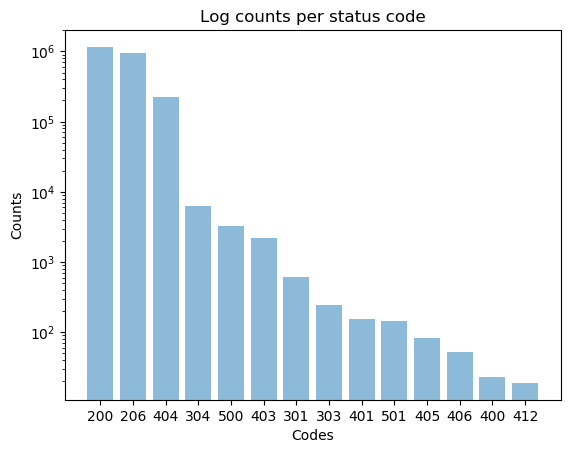

In [72]:
import matplotlib.pyplot as plt
plt.rcdefaults()

import numpy as np

y_pos = np.arange(len(responses))


plt.bar(y_pos, counts, align='center', alpha=0.5, log = True)
plt.xticks(y_pos, responses)
plt.ylabel('Counts')
plt.xlabel('Codes')

plt.title('Log counts per status code')

plt.show()

# How many unique hosts are there in the entire log and their average request

In [21]:
from urllib.parse import urlparse
hosts = url_count_rdd.map(lambda row: (urlparse(row[0]).netloc, row[1]) )

In [212]:
hosts.count()

11241

In [215]:
hosts_counts = hosts.reduceByKey(lambda x, y: x + y).sortBy(lambda a: -a[1])
hosts_counts.count()

4956

In [216]:
hosts_counts.toDF().toPandas()

,_1,_2
0,www.almhuette-raith.at,1207208
1,almhuette-raith.at,408303
2,www.jobboerse.com,3147
3,site.ru,2588
4,ALMHUETTE-RAITH.AT,1510
...,...,...
4951,www.pov4.com,1
4952,yaderenergy.ru,1
4953,acheter-nitroglycerin.comunidades.net,1
4954,betapace-kaufen.page.tl,1
